In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import sklearn.neighbors as knn
import and_logic_generator as and_gen
import utils
import applicability_domain as ad
import adversarial_generator as adversarial

# reload modules every 2 seconds
%load_ext autoreload
%autoreload 2


In [2]:
# Repeatable seed
random_state = 2**12
np.random.seed(seed=random_state)


In [3]:
# generating 4 blobs instead of 1.
n = 2000
centres = [
    [0.25, 0.25],
    [0.75, 0.25],
    [0.25, 0.75],
    [0.75, 0.75]]
x = np.array([], dtype=np.float32)
y = np.array([], dtype=np.int)
for centre in centres:
    temp_x, temp_y = and_gen.generate_logistic_samples(
        n=int(n / len(centres)), threshold=0.5, centre=centre,
        scale=0.05)
    # numpy append func does NOT allow preallocate multi-dimensional array
    if len(x) == 0:
        x = temp_x
    else:
        x = np.append(x, temp_x, axis=0)
    y = np.append(y, temp_y)

x = x - 0.5
x, x_norms = normalize(x, norm='l2', axis=0, return_norm=True)
print('Norms:')
print(x_norms)


Norms:
[11.74029883 11.90490709]


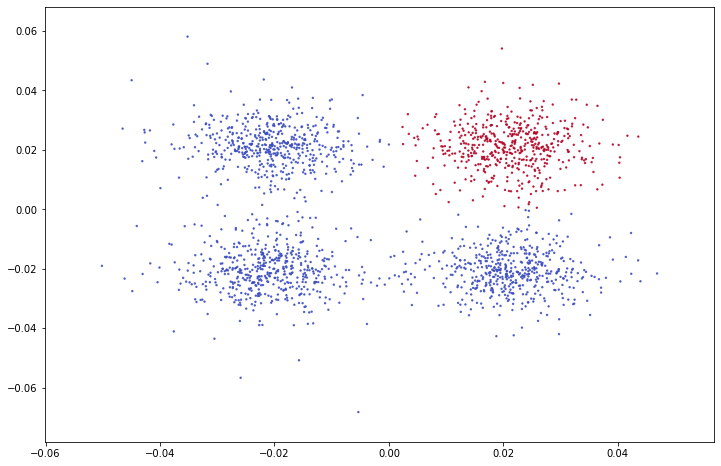

In [4]:
# Increasing the size of the plots
figsize = np.array(plt.rcParams["figure.figsize"]) * 2

x_max = np.amax(x, axis=0) + 0.01
x_min = np.amin(x, axis=0) - 0.01

plt.figure(figsize=figsize.tolist())
plt.scatter(
    x[:, 0], x[:, 1], marker='.', c=y, alpha=0.8, cmap='coolwarm',
    s=8, edgecolor='face')
plt.grid(False)
plt.xlim(x_min[0], x_max[0])
plt.ylim(x_min[1], x_max[1])
plt.show()


In [5]:
# 60:40 split on training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4)


In [6]:
# Prediction model
# This model does NOT aware of adversarial examples.
# SVM
gamma = 'scale'
C = 100

model_svm = svm.SVC(
    kernel='rbf', random_state=random_state, gamma=gamma, C=C)
model_svm.fit(x_train, y_train)

pred_train = model_svm.predict(x_train)
score_train = accuracy_score(y_train, pred_train)

pred_test = model_svm.predict(x_test)
score_test = accuracy_score(y_test, pred_test)

print(f'With gamma = {gamma} and C = {C}')
print(f'Accuracy on train set = {score_train*100:.4f}%')
print(f'Accuracy on test set  = {score_test*100:.4f}%')


With gamma = scale and C = 100
Accuracy on train set = 100.0000%
Accuracy on test set  = 99.7500%


In [7]:
# Sanity check
x_basis, y_basis = and_gen.get_basic_set(shift=[[-0.5, -0.5]], norms=[x_norms])
utils.run_basic_test(x_basis, y_basis, model_svm)


Pass basic test


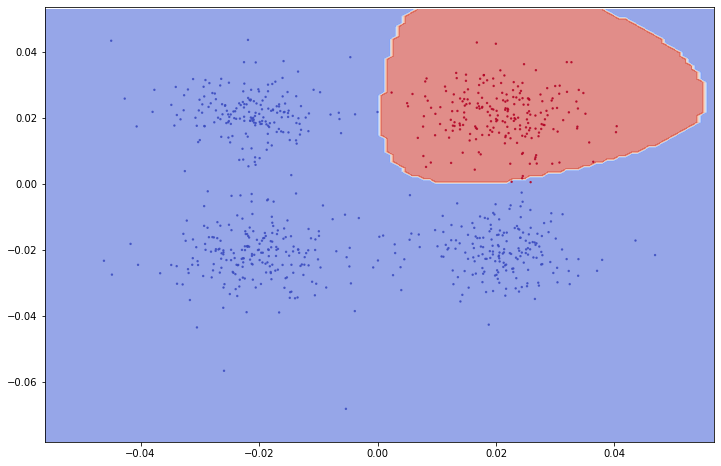

In [8]:
h = .001
# by symmetry x and y axis should be in same range
x_max = np.amax(x_test, axis=0) + 0.01
x_min = np.amin(x_test, axis=0) - 0.01

xx, yy = np.meshgrid(
    np.arange(x_min[0], x_max[0], h), 
    np.arange(x_min[1], x_max[1], h))
Z = model_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=figsize.tolist())
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)
plt.scatter(
    x_test[:, 0], x_test[:, 1], c=y_test, marker='.', alpha=0.8,
    cmap='coolwarm', s=8, edgecolor='face')
plt.xlim(x_min[0], x_max[0])
plt.ylim(x_min[1], x_max[1])
plt.show()


In [9]:
model_svm.get_params()


{'C': 100,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 4096,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [10]:
# Creating adversarial examples
# Grey-box scenario, the attacker has the access on the training set
ind_train_c1 = np.where(y_train == 1)
x_train_c1 = x_train[ind_train_c1]
y_train_c1 = np.ones(len(x_train_c1))
mu_train_c1 = np.mean(x_train_c1, axis=0)

ind_train_c0 = np.where(y_train == 0)
x_train_c0 = x_train[ind_train_c0]
y_train_c0 = np.zeros(len(x_train_c0))
mu_train_c0 = np.mean(x_train_c0, axis=0)

print(f'Positive mean = [{mu_train_c1[0]:.4f}, {mu_train_c1[1]:.4f}]')
print(f'Negative mean = [{mu_train_c0[0]:.4f}, {mu_train_c0[1]:.4f}]')


Positive mean = [0.0216, 0.0213]
Negative mean = [-0.0067, -0.0061]


In [11]:
# Generating Adversarial Examples from test set
# This implementation uses multiple iterations to update x, until all of them
# match the target classes.
epsilon = 0.0006

adversarial_examples = np.copy(x_test)  # make a clone
pred = pred_test
# Aimed to generate labels which completely opposite to the true labels, 
# not the prediction from SVM.
targets = and_gen.get_not_y(y_test)

epoch = 1
while np.array_equal(pred, targets) == False:
    adversarial_examples = adversarial.moving_mean(
        x=adversarial_examples,
        y=pred,
        targets=targets,
        means={0: mu_train_c0, 1: mu_train_c1},
        epsilon=epsilon,
        verbose=0,
        epoch=epoch)
    pred = model_svm.predict(adversarial_examples)
    epoch += 1

print(f'Completed after {epoch} epoch.')


Completed after 116 epoch.


In [12]:
# Results
original_pred = model_svm.predict(x_test)
pred_ae = model_svm.predict(adversarial_examples)
y_ae = and_gen.get_y(adversarial_examples)

matches = np.equal(y_ae, pred_ae)
ind_misclassified = np.where(matches == False)[0]

# Print all misclassified samples
# for i in ind_misclassified:
#     print(
#         f'from [{x_test[i][0]: .4f}, {x_test[i][1]: .4f}] = {original_pred[i]}'
#         + f' to [{adversarial_examples[i][0]: .4f}, '
#         + f'{adversarial_examples[i][1]: .4f}] = {pred_ae[i]};'
#         + f' True y = {y_ae[i]}')

y_miss = y_ae[ind_misclassified]
print(f'Misclassified positive = {len(y_miss[y_miss==1])}')
print(f'Misclassified negative = {len(y_miss[y_miss==0])}')

count = len(matches[matches==False])
print(f'\nFound {len(ind_misclassified)} Adversarial Examples out of ' 
    + f'{len(y_ae)}. {len(ind_misclassified) / len(y_ae) * 100.0:.4f}% '
    + 'successful rate')


Misclassified positive = 0
Misclassified negative = 583

Found 583 Adversarial Examples out of 800. 72.8750% successful rate


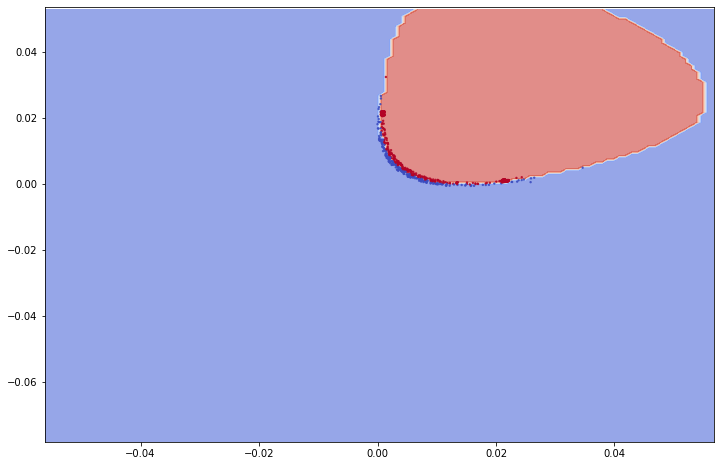

In [13]:
xx, yy = np.meshgrid(
    np.arange(x_min[0], x_max[0], h), 
    np.arange(x_min[1], x_max[1], h))
Z = model_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=figsize.tolist())
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)
plt.scatter(
    adversarial_examples[:, 0], adversarial_examples[:, 1], 
    c=pred_ae, marker='.', alpha=0.8, cmap='coolwarm', s=8, edgecolor='face')
plt.xlim(x_min[0], x_max[0])
plt.ylim(x_min[1], x_max[1])
plt.show()


In [14]:
# Apply Applicability Domain
# Use the adversarial examples from previous step
x_ae = adversarial_examples
y_ae = and_gen.get_y(x_ae)
pred_ae = pred_ae = model_svm.predict(x_ae)
score = accuracy_score(y_ae, pred_ae)

print(f'Accuracy on the given set = {score*100:.4f}%')

# Applicability Domain
# Stage 1 - Applicability
print('\n---------- Applicability ---------------')
x_passed_s1, ind_passed_s1 = ad.check_applicability(x_ae, x_train, y_train)
pred_passed_s1 = pred_ae[ind_passed_s1]

# Print
pass_rate = utils.get_rate(x_passed_s1, x_ae)
print(f'Pass rate = {pass_rate * 100:.4f}%')
# print('Blocked by Applicability Domain:')
# utils.print_blocked_samples(x_ae, ind_passed_s1)


Accuracy on the given set = 27.1250%

---------- Applicability ---------------
Pass rate = 100.0000%


In [15]:
# Stage 2 - Reliability
print('\n---------- Reliability -----------------')
# Parameters:
k = 9
# Using a larger zeta value
# zeta = 1.2
zeta0 = 3.2
zeta1 = 1.7

# Creating kNN models for each class
ind_train_c0 = np.where(y_train == 0)
model_knn_c0 = utils.unimodal_knn(x_train[ind_train_c0], k)

ind_train_c1 = np.where(y_train == 1)
model_knn_c1 = utils.unimodal_knn(x_train[ind_train_c1], k)

# Computing mean, standard deviation and threshold
mu_c0, sd_c0 = utils.get_distance_info(
    model_knn_c0, x_train[ind_train_c0], k, seen_in_train_set=True)
threshold_c0 = ad.get_reliability_threshold(mu_c0, sd_c0, zeta0)

mu_c1, sd_c1 = utils.get_distance_info(
    model_knn_c1, x_train[ind_train_c1], k, seen_in_train_set=True)
threshold_c1 = ad.get_reliability_threshold(mu_c1, sd_c1, zeta1)

x_passed_s2, ind_passed_s2 = ad.check_reliability(
    x_passed_s1,
    predictions=pred_passed_s1,
    models=[model_knn_c0, model_knn_c1],
    dist_thresholds=[threshold_c0, threshold_c1],
    classes=[0, 1],
    verbose=1
)
pred_passed_s2 = pred_passed_s1[ind_passed_s2]

# Print
print('Distance of c0 in training set:')
print('{:18s} = {:.4f}'.format('Mean', mu_c0))
print('{:18s} = {:.4f}'.format('Standard deviation', sd_c0))
print('{:18s} = {:.4f}\n'.format('Threshold', threshold_c0))

print('Distance of c1 in training set:')
print('{:18s} = {:.4f}'.format('Mean', mu_c1))
print('{:18s} = {:.4f}'.format('Standard deviation', sd_c1))
print('{:18s} = {:.4f}\n'.format('Threshold', threshold_c1))

pass_rate = utils.get_rate(x_passed_s2, x_passed_s1)
print(f'Pass rate = {pass_rate * 100:.4f}%')
# print('Blocked by Reliability Domain:')
# utils.print_blocked_samples(x_passed_s1, ind_passed_s2)



---------- Reliability -----------------

In 0 class:
Threshold = 0.0082
Average mean = 0.0101
Passed indices:
5, 7, 44, 54, 55, 61, 92, 96, 132, 136, 161, 164, 188, 197, 214, 237, 253, 254, 255, 285, 287, 288, 310, 329, 332, 333, 339, 346, 347, 352, 353, 365, 411, 423, 424, 438, 445, 457, 485, 497, 501, 507, 510, 565, 568, 569, 593, 594, 597, 600, 610, 632, 655, 665, 705, 708, 735, 745, 766, 770, 776, 780, 796

In 1 class:
Threshold = 0.0054
Average mean = 0.0068
Passed indices:
2, 3, 11, 13, 15, 27, 34, 35, 36, 40, 43, 45, 48, 50, 60, 64, 66, 69, 71, 84, 93, 94, 98, 102, 111, 119, 120, 121, 124, 127, 128, 131, 135, 146, 153, 163, 167, 170, 177, 179, 182, 186, 193, 194, 196, 202, 204, 206, 211, 213, 221, 225, 227, 230, 231, 232, 238, 239, 240, 241, 244, 251, 256, 259, 267, 274, 276, 286, 289, 290, 291, 294, 297, 298, 300, 302, 306, 309, 312, 316, 317, 322, 336, 337, 341, 348, 350, 351, 355, 363, 364, 366, 367, 369, 373, 375, 378, 381, 386, 387, 396, 397, 401, 402, 405, 407, 418, 420,

In [16]:
# Stage 3 - Decidability
print('\n---------- Decidability ----------------')
model_knn = knn.KNeighborsClassifier(
    n_neighbors=k, n_jobs=-1, weights='distance')
model_knn.fit(x_train, y_train)

x_passed_s3, ind_passed_s3 = ad.check_decidability(
    x_passed_s2, pred_passed_s2, model_knn)


# Print
pass_rate = utils.get_rate(x_passed_s3, x_passed_s2)
print(f'Pass rate = {pass_rate * 100:.4f}%')
# print('Blocked by Decidability Domain:')
# utils.print_blocked_samples(x_passed_s2, ind_passed_s3)



---------- Decidability ----------------
Pass rate = 91.7647%


In [17]:
# Results
score = accuracy_score(y_ae, pred_ae)
print(f'Accuracy before AD = {score*100:.4f}%')

pass_rate = utils.get_rate(x_passed_s3, x_ae)
print(f'\nOverall pass rate = {pass_rate * 100:.4f}%')

if len(x_passed_s3) is not 0:
    y_passed = and_gen.get_y(x_passed_s3)
    pred_after_ad = model_svm.predict(x_passed_s3)
    score = accuracy_score(y_passed, pred_after_ad)
    matches = np.equal(y_passed, pred_after_ad)
    ind_misclassified = np.where(matches == False)[0]

    print(f'Accuracy after AD = {score*100:.4f}%')
    print(f'{len(x_passed_s3)} out of {len(x_ae)}')
    print(f'Misclassified = {len(ind_misclassified)}')
    y_miss = y_passed[ind_misclassified]
    print(f'Misclassified positive = {len(y_miss[y_miss==1])}')
    print(f'Misclassified negative = {len(y_miss[y_miss==0])}')
print()


Accuracy before AD = 27.1250%

Overall pass rate = 29.2500%
Accuracy after AD = 17.9487%
234 out of 800
Misclassified = 192
Misclassified positive = 0
Misclassified negative = 192



In [18]:
for i in ind_misclassified:
    print(
        f'[{adversarial_examples[i][0]: .4f}, ' 
        + f'{adversarial_examples[i][1]: .4f}] = {pred_after_ad[i]};'
        + f' True y = {y_passed[i]}')


[ 0.0008,  0.0218] = 1; True y = 0
[ 0.0007,  0.0219] = 1; True y = 0
[ 0.0216,  0.0010] = 1; True y = 0
[ 0.0090,  0.0005] = 1; True y = 0
[ 0.0008,  0.0112] = 1; True y = 0
[ 0.0021,  0.0091] = 1; True y = 0
[ 0.0006,  0.0259] = 1; True y = 0
[ 0.0019,  0.0094] = 1; True y = 0
[ 0.0009,  0.0208] = 1; True y = 0
[ 0.0053,  0.0025] = 1; True y = 0
[ 0.0243,  0.0020] = 1; True y = 0
[ 0.0007,  0.0212] = 1; True y = 0
[ 0.0219,  0.0010] = 1; True y = 0
[ 0.0045,  0.0031] = 1; True y = 0
[ 0.0221,  0.0009] = 1; True y = 0
[ 0.0074,  0.0022] = 1; True y = 0
[ 0.0078,  0.0008] = 1; True y = 0
[ 0.0133,  0.0002] = 1; True y = 0
[ 0.0046,  0.0043] = 1; True y = 0
[ 0.0346,  0.0049] = 1; True y = 0
[ 0.0102,  0.0010] = 1; True y = 0
[ 0.0044,  0.0041] = 1; True y = 0
[ 0.0036,  0.0045] = 1; True y = 0
[ 0.0033,  0.0066] = 1; True y = 0
[ 0.0007,  0.0213] = 1; True y = 0
[ 0.0218,  0.0011] = 1; True y = 0
[ 0.0107,  0.0007] = 1; True y = 0
[ 0.0008,  0.0219] = 1; True y = 0
[ 0.0215,  0.0007] =

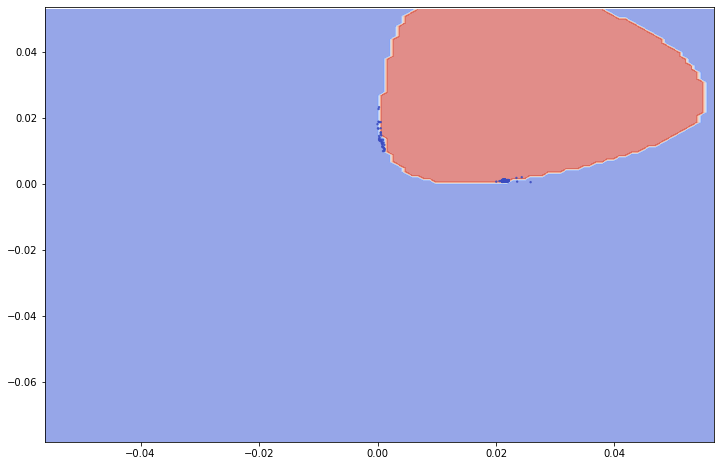

In [19]:
xx, yy = np.meshgrid(
    np.arange(x_min[0], x_max[0], h), 
    np.arange(x_min[1], x_max[1], h))
Z = model_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=figsize.tolist())
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)
plt.scatter(
    x_passed_s3[:, 0], x_passed_s3[:, 1], 
    c=y_passed, marker='.', alpha=0.8, cmap='coolwarm', s=8, edgecolor='face')
plt.xlim(x_min[0], x_max[0])
plt.ylim(x_min[1], x_max[1])
plt.show()
